# <font color='#f78fb3'> **1 Overview**<br> </font> 

---
---
# <font color='#f78fb3'> **2 Setup**<br> </font> 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import sklearn.decomposition as dec
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Common imports
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from sparsesvd import sparsesvd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from math import sqrt


# to make this notebook's output stable across runs
np.random.seed(42)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import seaborn to make nice plots
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_data(X, y, n_cluster):
    palette = np.array(sns.color_palette("hls", n_cluster))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sc = ax.scatter(X[:,0], X[:,1], s=3,c=y, cmap="jet")
    # We add the labels for each digit.
    txts = []
    for i in range(n_cluster):
        # Position of each label.
        xtext, ytext = np.median(X[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
                PathEffects.Stroke(linewidth=3, foreground="w"),
                PathEffects.Normal()])
        txts.append(txt)    
        
        
def compare_truelabel_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    ax[0].scatter(X[:,0], X[:,1], s=3, c=y, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], s=3, c=cluster, cmap='jet')
    plt.axis('off')
    plt.show()
    
    
def show_image(images, n_images=5):
    nrows, ncols = 1, 5
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    plt.gray()
    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(images.reshape(len(images),28,28)[i])
        plt.xticks([])
        plt.yticks([])    
            
    plt.show()


---
---
# <font color='#f78fb3'> **3 Data Preparation**<br> </font> 

### Full dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape(-1,784)
X_test = X_test.reshape(-1,784)

X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

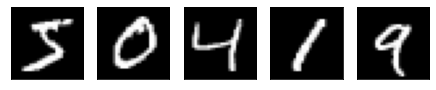

In [4]:
show_image(X_train_full[0:5], 5)

### Use a part of full dataset to reduce the training time

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[45000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[45000:]
X_test = X_test / 255.

X_train.shape, X_valid.shape, X_test.shape

((15000, 784), (5000, 784), (10000, 784))

---
---
# <font color='#f78fb3'> **4 PCA**<br> </font> 

### 1. Train model

In [7]:
pca = PCA()
X_train_pca = pca.fit(X_train)

### 2. Select number of principle components

153


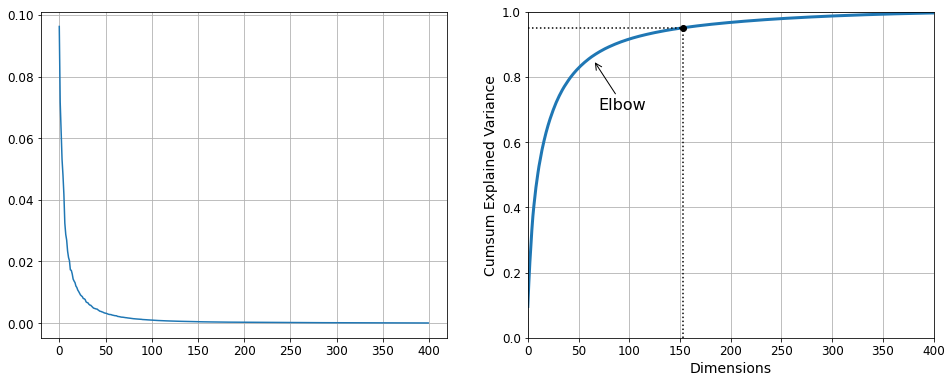

In [8]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)
   
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(pca.explained_variance_ratio_[0:400])
ax[0].grid(True)

ax[1].plot(cumsum, linewidth=3)
ax[1].axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Explained Variance")
ax[1].plot([d, d], [0, 0.95], "k:")
ax[1].plot([0, d], [0.95, 0.95], "k:")
ax[1].plot(d, 0.95, "ko")
ax[1].annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### 3.  Fit and transform with 85% of variance

In [9]:
pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train)
X_recovered_pca = pca.inverse_transform(X_train_pca)

pca.n_components_, np.sum(pca.explained_variance_ratio_)

(60, 0.8523807103955257)

### 4. Plot transformed data

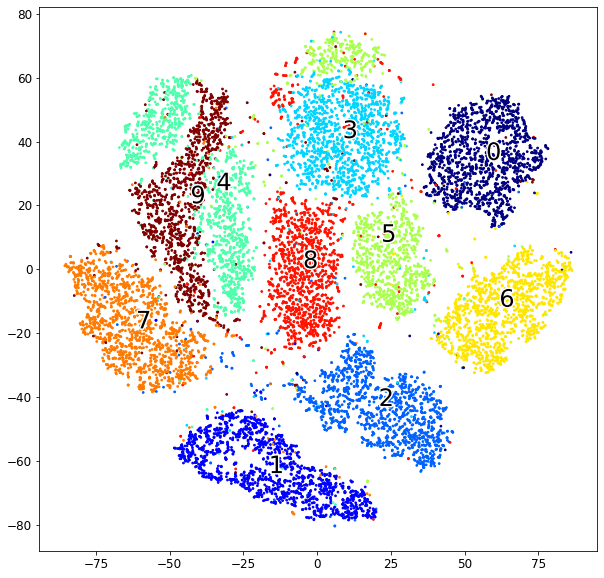

In [10]:
tsne = TSNE(n_components=2, random_state=42)
pca_tsne_value = tsne.fit_transform(X_train_pca)
plot_data(pca_tsne_value, y_train, 10)

---
---
# <font color='#f78fb3'> **5 SVD**<br> </font> 

### 1. Train model

In [11]:
U, S, V = np.linalg.svd(X_train)
S[0:10]

array([747.62823649, 255.5026409 , 237.44486297, 220.58915713,
       204.45551277, 182.29187181, 169.30560206, 151.21702539,
       149.81213795, 135.62240471])

### 2.  Select number of latent vars

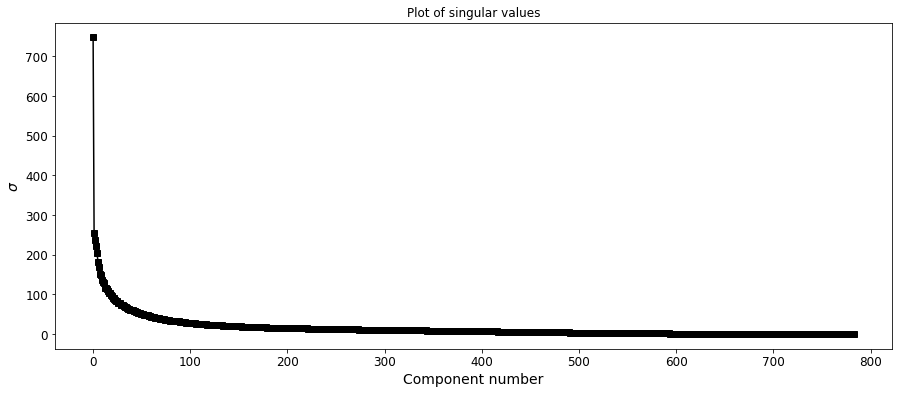

In [12]:
plt.figure(figsize=(15,6))
plt.plot(S, 'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('Plot of singular values')
plt.show()

In [13]:
# list the components you want to use for the reconstruction
n_comps = np.arange(0,30)

# reconstruct the low-rank version of the picture
X_pred = U[:,n_comps]@np.diag(S[n_comps])@V[:,n_comps].T

In [14]:
X_train[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X_pred[0:3]

array([[-1.48088366e-16, -1.84571270e-16, -3.11626525e-17, ...,
         0.00000000e+00,  6.75169064e+00, -3.65673715e-01],
       [-3.83823703e-16, -2.12749341e-16,  2.55679620e-16, ...,
         0.00000000e+00,  5.23295521e+00,  1.58672147e+00],
       [-2.83722550e-16, -2.39493136e-16,  2.65863423e-17, ...,
         0.00000000e+00,  3.61726928e+00, -1.34550291e+00]])

### 3. Visualize latent vars

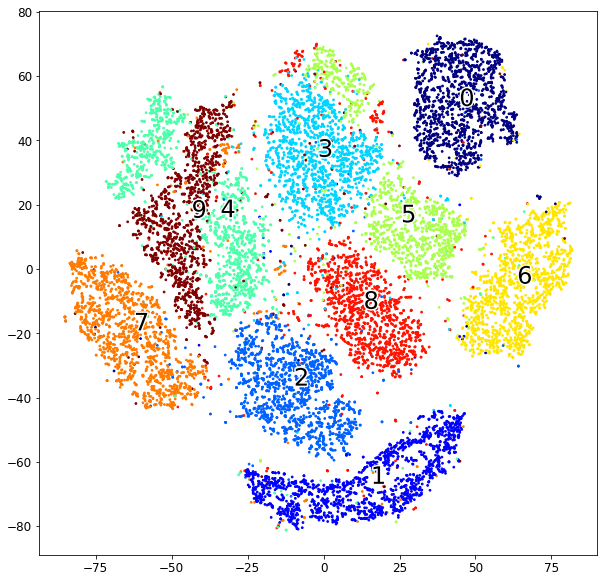

In [16]:
tsne = TSNE(n_components=2, random_state=42)
svd_tsne_value = tsne.fit_transform(U[:,n_comps])
plot_data(svd_tsne_value, y_train, 10)

---
---
# <font color='#f78fb3'> **6 Auto Encoder**<br> </font> 

### 1. Import library

In [16]:
# Deep Learnign libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex
import datetime

### 2.  Construct architecture

In [17]:


tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 100
encoding2_dim = 500
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 500)               50500     
                                                                 
 dense_2 (Dense)             (None, 20)                10020     
                                                                 
 dense_3 (Dense)             (None, 500)               10500     
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 dense_5 (Dense)             (None, 784)               79184 

In [18]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

### 3. Train model

In [19]:
nb_epoch = 20
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_data=(X_valid, X_valid),
                          #verbose=1,
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/20
469/469 [==============================] - 6s 8ms/step - loss: 0.0431 - val_loss: 0.0305
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0283 - val_loss: 0.0265
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0257 - val_loss: 0.0246
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0205 - val_loss: 0.0208

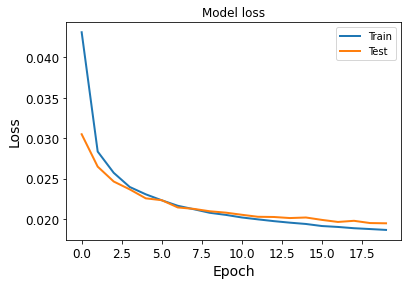

In [20]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### 4. Transform data to embedding layer

In [21]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_train_ae = encoder_layer.predict(X_train)
X_train_ae_tsne = tsne.fit_transform(X_train_ae)

#### Visualize transformed data

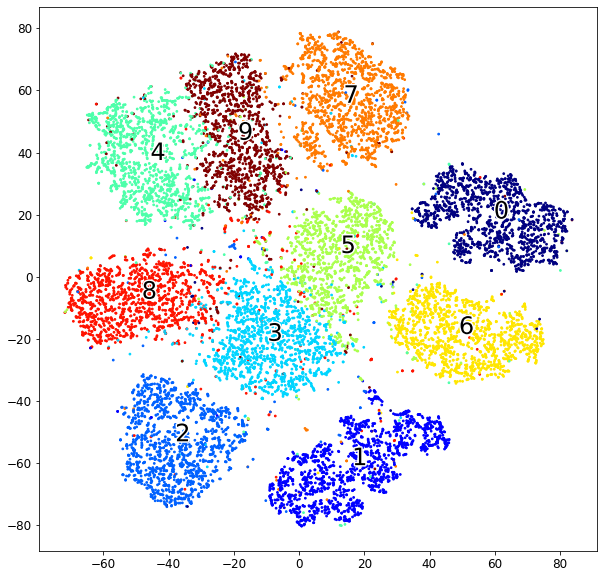

In [22]:
plot_data(X_train_ae_tsne, y_train, 10)

In [23]:
pd.DataFrame(X_train_ae).to_csv('Mnist_ae.csv', index=False)
pd.DataFrame(X_train_ae_tsne).to_csv('Mnist_ae_tsne.csv', index=False)

---
---
# <font color='#f78fb3'> **7 Variational Auto Encoder**<br> </font> 

### 1. Cost function

In [24]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

### 2. Train model

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 20

inputs = keras.layers.Input(shape=[784])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(100, activation="selu")(z)
z = keras.layers.Dense(500, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(784, activation="selu")(x)
outputs = keras.layers.Reshape([784])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="adam")
history = variational_ae.fit(X_train, X_train, epochs=20, #batch_size=5000,
                             validation_data=(X_valid, X_valid))
df_history = pd.DataFrame(history.history)

Epoch 1/20
469/469 [==============================] - 6s 11ms/step - loss: 0.0629 - val_loss: 0.0544
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0534 - val_loss: 0.0526
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0522 - val_loss: 0.0518
Epoch 4/20
469/469 [==============================] - 4s 10ms/step - loss: 0.0515 - val_loss: 0.0509
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0506 - val_loss: 0.0503
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0498 - val_loss: 0.0493
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0491 - val_loss: 0.0486
Epoch 8/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0486 - val_loss: 0.0483
Epoch 9/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0482 - val_loss: 0.0479
Epoch 10/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0479 - val_loss: 

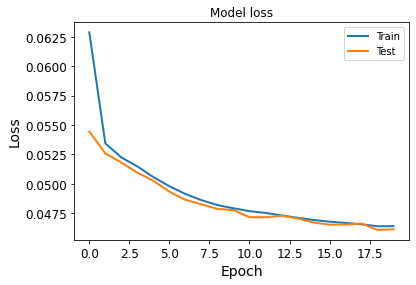

In [26]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### 3.  Transform data to embedding layer

In [27]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_train_vae = variational_encoder.predict(X_train)[0]

#### Visualize transformed data

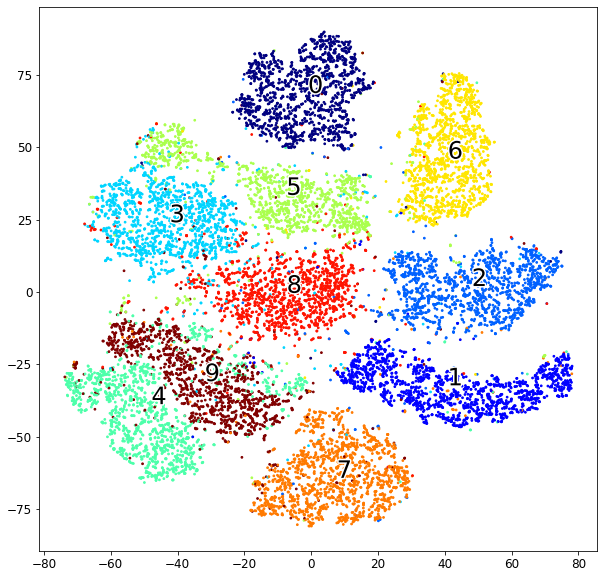

In [28]:
X_train_vae_tsne = tsne.fit_transform(X_train_vae)

plot_data(X_train_vae_tsne, y_train, 10)